In [2]:
import os
import pandas as pd
import json
from statistics import mean
    
def get_traces_stat(dir_path):
    """ This function read all files, of type csv with specific structure. The samples (voltage) are filtered and stored in a data frame,
        where the trigger value is above the threshold.

        Then the mean value of the filtered data will be stored in a dict, and this operation will be repeated for all files in the specified
        directory. At the end, the items in the dict are sorted in increasing order (since we are waiting file name's ending with a number representing
        the number of measurement).

        The best practice while using this function, is to get the average of a desired instruction that have several measurements in a single directory.

    """
    traces_stat = {
        "power": {},
        "time": {}
    }

    for filename in os.listdir(dir_path):
        relative_path = os.path.join(dir_path, filename)

        # checking if it is a file
        if os.path.isfile(relative_path) and relative_path.endswith('.csv'):

            # read data
            df = pd.read_csv(relative_path, skiprows=10)
            df.columns = ['time', 'data', 'trig']
            rslt_df= df[df['trig'] > 2.5] # filter samples where trigger is active (High)
            # rslt_df= rslt_df.iloc[50:100, ::]

            # calculate stats
            if filename.replace('.csv', '') not in traces_stat:
                traces_stat[filename.replace('.csv', '')] = {}

            traces_stat['power'][filename.replace('.csv', '')] =  rslt_df['data'].mean()
            traces_stat['time'][filename.replace('.csv', '')] =  rslt_df['time'].iloc[-1]-rslt_df['time'].iloc[0]
    
    # sort dictionary keys
    traces_stat['power'] = dict( sorted(traces_stat['power'].items(), key=lambda x: int(x[0].split('_')[-1])) )
    
    return traces_stat

def get_all_traces_stat(dir_path, unit = "uA"):
    """ The following function will iterate over several instruction file to apply the 'get_traces_stat()' function.
        It will automate the capture of the average of all instructions stored in one file. Taken into consederation that you can add custom 
        statistical parameters to the called function 'get_traces_stat()' to get detailed info.

        The average values corresponds either to the voltage on the shunt resistor, or to the current passing through the shunt resistor. 
        
        Also, you can specify the desired unit using unit parameter.
        Valid options for the unit parameter are: 'A', 'mA', 'uA', 'V', 'mV', 'uV'
        """
    all_traces_stat = {}

    # Measured data is in Voltage (V), and R_shunt = 0.1 Ohms
    if unit == "uA":
        scalar = 1e7
    elif unit == "A":
        scalar = 1e1
    elif unit == "mA":
        scalar = 1e4
    elif unit == "mV":
        scalar = 1e3
    elif unit == "uV":
        scalar = 1e6
    elif unit == "V":
        scalar = 1

    t_cycle= 0.05e-6 # micro-seconds, since freq= 20MHz

    for sub_dir_name in os.listdir(dir_path):
        relative_path = os.path.join(dir_path, sub_dir_name)
        # checking if it is a dir
        if os.path.isdir(relative_path):
            i_stat = get_traces_stat(relative_path)
            # print(i_stat)
            i_mean = mean(i_stat['power'].values())*scalar
            i_cycles = mean(i_stat['time'].values())
            i_cycles = round(i_cycles/t_cycle) # ground division to get int

            all_traces_stat[sub_dir_name]= {
                "power": i_mean,
                "cycles": i_cycles
            }

    return all_traces_stat

def save_stats_as_file(stat_dict, file_path):
    with open(file_path, 'w') as j_file:
        json.dump(stat_dict, j_file)



In [4]:
all_benchmark_traces = get_all_traces_stat("traces_bank_current_trigger/benchmark_traces") # only true time is needed in this case
save_stats_as_file(stat_dict=all_benchmark_traces, file_path="energy_files/voltage_benchmark_data.json")

In [3]:
all_benchmark_traces = get_all_traces_stat("traces_bank_current_trigger/benchmark_traces")
save_stats_as_file(stat_dict=all_benchmark_traces, file_path="results/benchmarks_data.json")

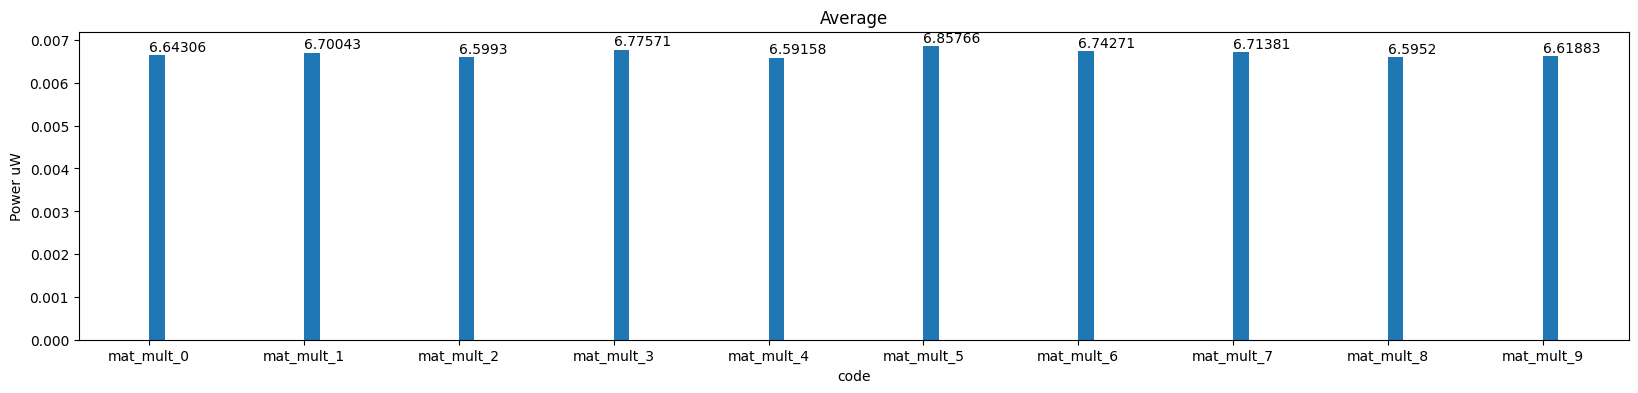

In [2]:
import matplotlib.pyplot as plt

fib_100MHz_40 = get_traces_stat("traces_bank_current_trigger/benchmark_traces/matrix_mult_50MHz_3x3")

plt.figure(figsize=(20, 4))
plt.title(f"Average")
plt.bar(fib_100MHz_40['power'].keys(), fib_100MHz_40['power'].values(), width=0.1, align= 'edge')
for i, v in enumerate(fib_100MHz_40['power'].values()):
    plt.text(i, v +0.0001, str(round(v*1000, 5)))
plt.xlabel("code")
plt.ylabel("Power uW")
plt.show()

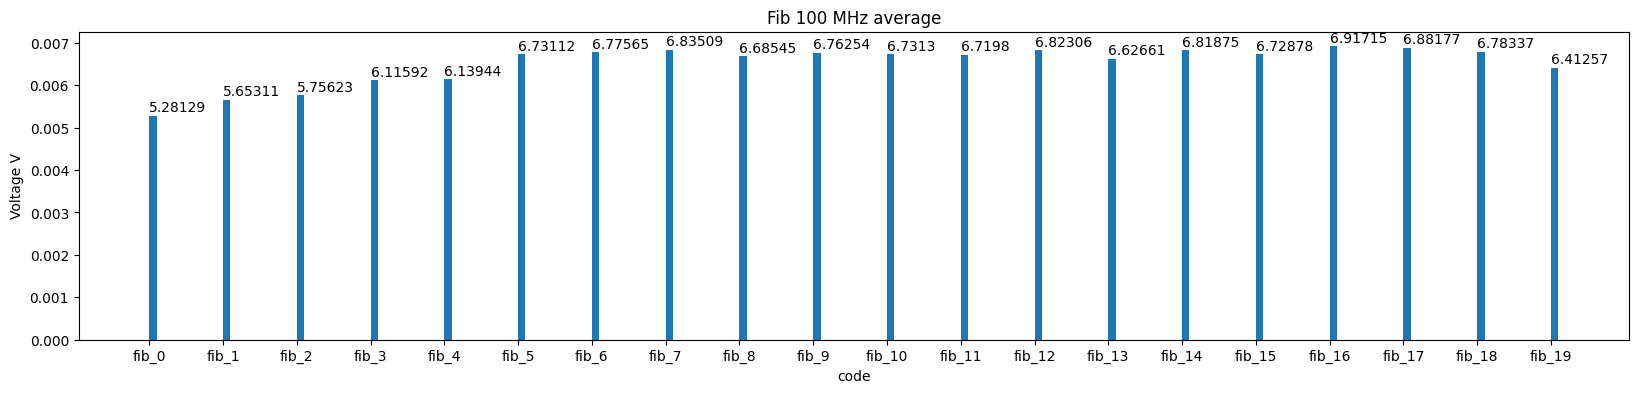

In [3]:
import matplotlib.pyplot as plt

fib_100MHz = get_traces_stat("traces_bank_current_trigger/benchmark_traces/fibonacci_100MHz")

plt.figure(figsize=(20, 4))
plt.title(f"Fib 100 MHz average")
plt.bar(fib_100MHz['average'].keys(), fib_100MHz['average'].values(), width=0.1, align= 'edge')
for i, v in enumerate(fib_100MHz['average'].values()):
    plt.text(i, v +0.0001, str(round(v*1000, 5)))
plt.xlabel("code")
plt.ylabel("Voltage V")
plt.show()

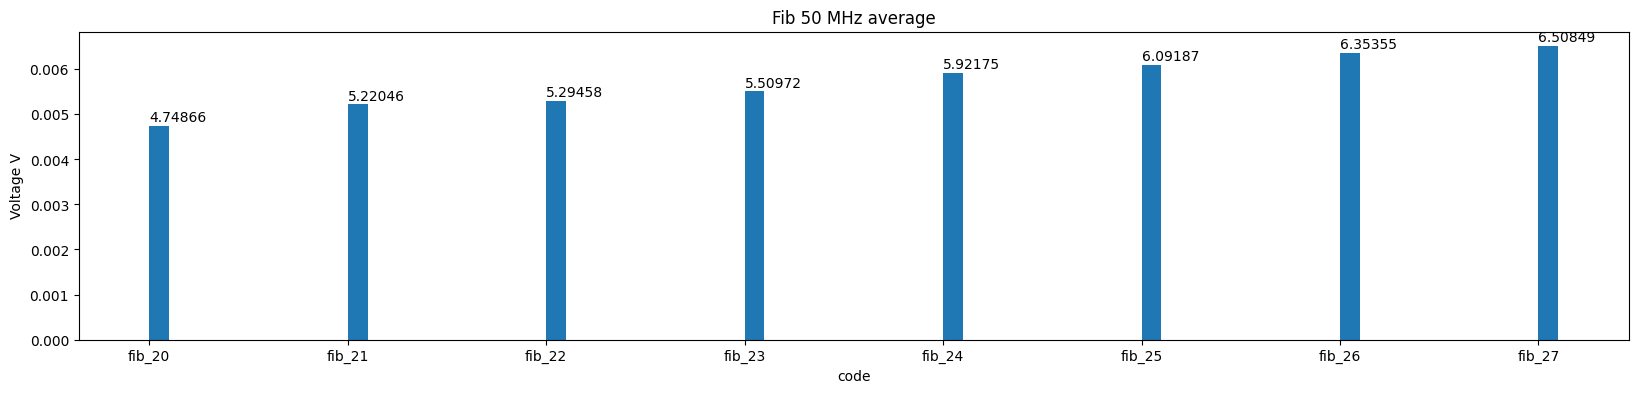

In [32]:
import matplotlib.pyplot as plt

fib_50MHz = get_traces_stat("traces_bank_current_trigger/benchmark_traces/fibonacci_50MHz")

x, y = list(fib_50MHz['average'].keys())[20::], list(fib_50MHz['average'].values())[20::]

plt.figure(figsize=(20, 4))
plt.title(f"Fib 50 MHz average")
plt.bar(x, y, width=0.1, align= 'edge')

for i, v in enumerate(y):
    plt.text(i, v + 0.0001, str(round(v*1000, 5)))

plt.xlabel("code")
plt.ylabel("Voltage V")
plt.show()

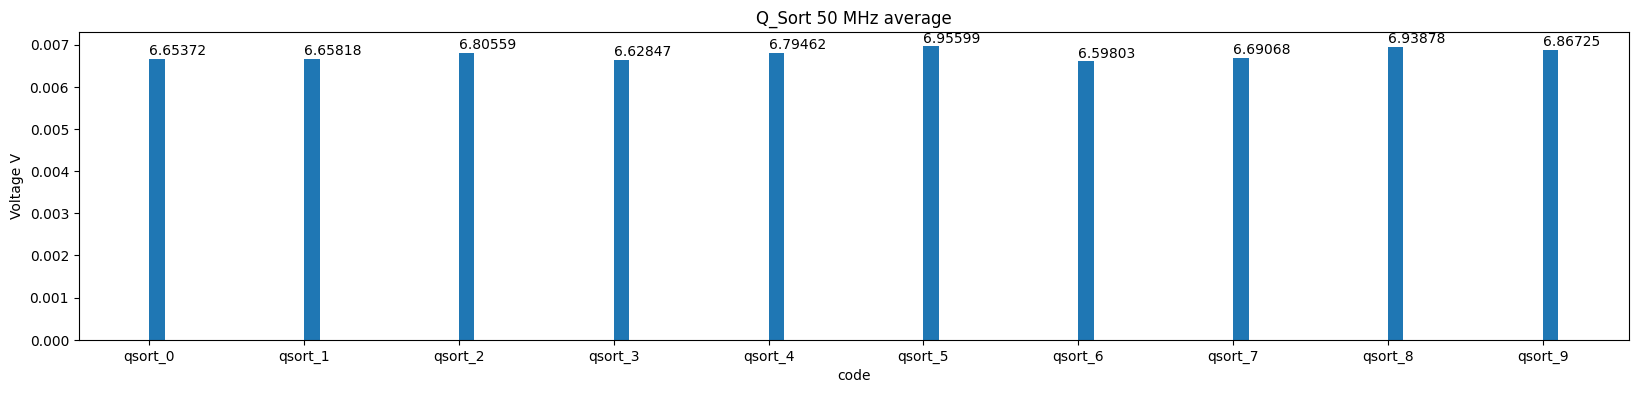

In [52]:
import matplotlib.pyplot as plt

qsort_50MHz = get_traces_stat("traces_bank_current_trigger/benchmark_traces/qsort_50MHz")

plt.figure(figsize=(20, 4))
plt.title(f"Q_Sort 50 MHz average")
plt.bar(qsort_50MHz['average'].keys(), qsort_50MHz['average'].values(), width=0.1, align= 'edge')
for i, v in enumerate(qsort_50MHz['average'].values()):
    plt.text(i, v + 0.0001, str(round(v*1000, 5)))
plt.xlabel("code")
plt.ylabel("Voltage V")
plt.show()

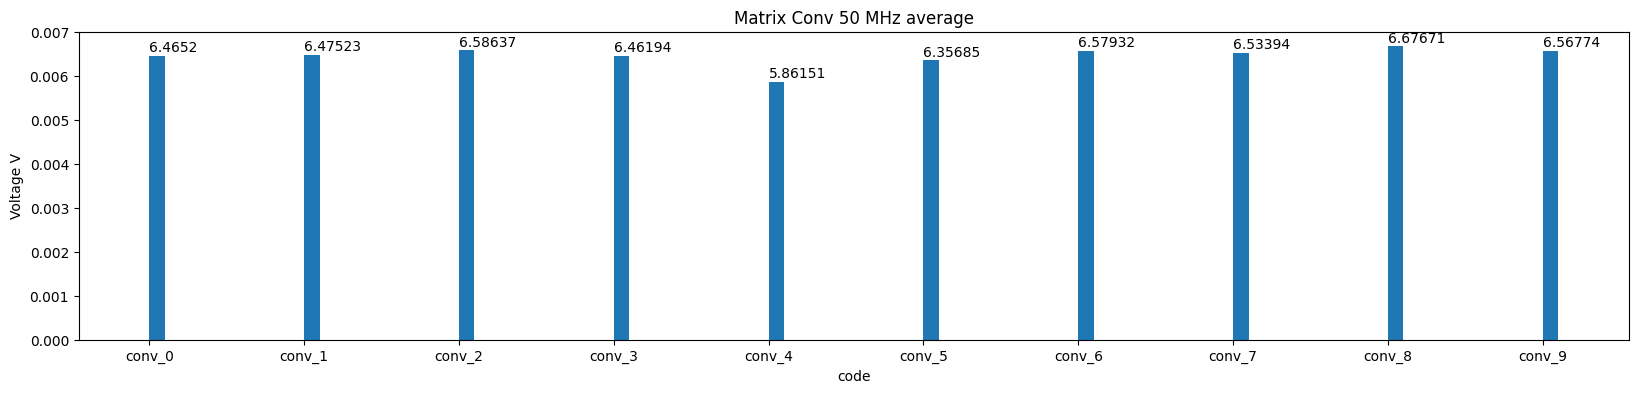

In [3]:
import matplotlib.pyplot as plt

conv_50MHz = get_traces_stat("traces_bank_current_trigger/benchmark_traces/matrix_conv_50MHz/") # New start from sample conv_4

x, y = list(conv_50MHz['average'].keys()), list(conv_50MHz['average'].values())

plt.figure(figsize=(20, 4))
plt.title(f"Matrix Conv 50 MHz average")
plt.bar(x, y, width=0.1, align= 'edge')

for i, v in enumerate(y):
    plt.text(i, v + 0.0001, str(round(v*1000, 5)))

plt.xlabel("code")
plt.ylabel("Voltage V")
plt.show()

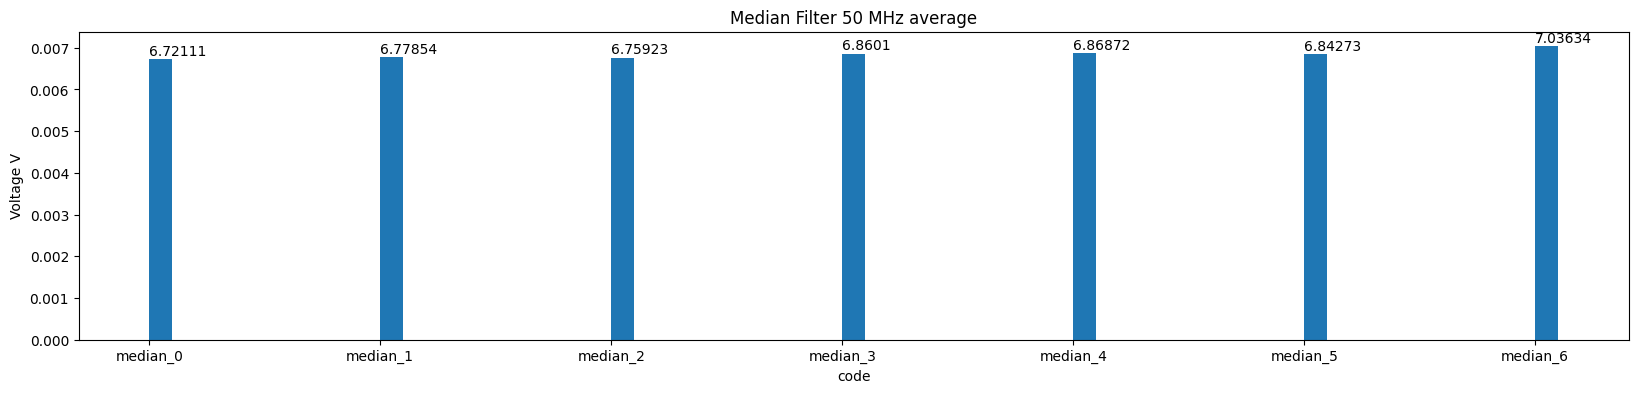

In [4]:
import matplotlib.pyplot as plt

median_50MHz = get_traces_stat("traces_bank_current_trigger/benchmark_traces/median_filter_50MHz")

plt.figure(figsize=(20, 4))
plt.title(f"Median Filter 50 MHz average")
plt.bar(median_50MHz['average'].keys(), median_50MHz['average'].values(), width=0.1, align= 'edge')
for i, v in enumerate(median_50MHz['average'].values()):
    plt.text(i, v + 0.0001, str(round(v*1000, 5)))
plt.xlabel("code")
plt.ylabel("Voltage V")
plt.show()